# Power Spectrum - P(k)

Here I try to run `nbodykit` to compute the cluster power spectrum. 

Following this notebook:\
https://nbodykit.readthedocs.io/en/latest/cookbook/convpower.html \
https://github.com/bccp/nbodykit-cookbook/blob/master/recipes/fftpower.ipynb

## Installing Nobdykit

If you don't have the package it might take some time to install it. In the NERSC computer I had to create a special environement for nbodykit.

```
conda create --name nbodykit-env python=3.7 # or use python=2 for python 2.7*
source activate nbodykit-env
conda install -c bccp nbodykit
```

Then, to add to your jupyter notebook environement.
```
pip install ipykernel
python -m ipykernel install --user --name=nbodykit-env
```

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# !pip install nbodykit

In [3]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [4]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [5]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [6]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
cosmo0 

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

In [7]:
kw = {'dS':r'$\Delta \Sigma \, \, [M_{\odot}]$',
      'gamma': r'$\left< \gamma_t(\theta) \right>$'}


## Adding the Catalog

In [35]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.mock_fname)

mock = Table(getdata(floc.mock_fname))

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0.fits


In [36]:
ran_all = Table(getdata('../correlationFunction/tmp_random.fits'))
# rm_all = Table(getdata('../correlationFunction/tmp_data.fits'))

In [51]:
data = Table(mock[['RA','DEC','redshift']])
data.rename_columns(['RA','DEC','redshift'], ['ra','dec','z'])

# data = rm_all[['ra','dec','z_lambda']]
# data.rename_column('z_lambda','z')
# # data = data.to_pandas()

select_good = (data['z']>=0.2) & (data['z']<=0.65)
select_good = select_good & ((data['z'] < 0.33)|(data['z'] > 0.37))
data = data[select_good]

randoms = ran_all[['ra','dec','ztrue','weight']]
randoms.rename_column('ztrue','z')

# take x 10 to start
# apply redshift cut 
select_good = (randoms['z']>=0.2) & (randoms['z']<=0.65)
select_good = select_good & ((randoms['z'] < 0.33)|(randoms['z'] > 0.37))

Nran = int(len(data)*40)
indices = np.random.randint(np.count_nonzero(select_good), size=Nran)
randoms = randoms[select_good][indices]

# randoms = randoms.to_pandas()

In [53]:
# import os 
# clobber=True
# if clobber | (not os.path.isfile('tmp_random.fits')):
#     randoms.write('tmp_random.fits',overwrite=True)
#     data.write('tmp_data.fits',overwrite=True)


In [54]:
# NOTE: change this path if you downloaded the data somewhere else!
# data_path = os.path.join(download_dir, 'galaxy_DR12v5_LOWZ_South.fits')
# randoms_path = os.path.join(download_dir, 'random0_DR12v5_LOWZ_South.fits')
randoms_path = 'tmp_random.fits'
data_path = 'tmp_data.fits'

# initialize the FITS catalog objects for data and randoms
data = FITSCatalog(data_path)
randoms = FITSCatalog(randoms_path)

## Estimating n(z)

A nice paper to understand the importance of the volume element in surveys:
https://arxiv.org/pdf/astro-ph/9304022.pdf

In [55]:
# plt.hist(randoms['z'])
# plt.hist(data['z'])

In [56]:
# # combine the data and randoms into a single catalog
# fkp = FKPCatalog(data, randoms, )

## Start Tutorial

In [57]:
# specify our cosmology
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.3)

# add Cartesian position column
data['Position'] = transform.SkyToCartesian(data['ra'], data['dec'], data['z'], cosmo=cosmo)
randoms['Position'] = transform.SkyToCartesian(randoms['ra'], randoms['dec'], randoms['z'], cosmo=cosmo)

Text(0, 0.5, '$n(z)$ $[h^{3} \\mathrm{Mpc}^{-3}]$')

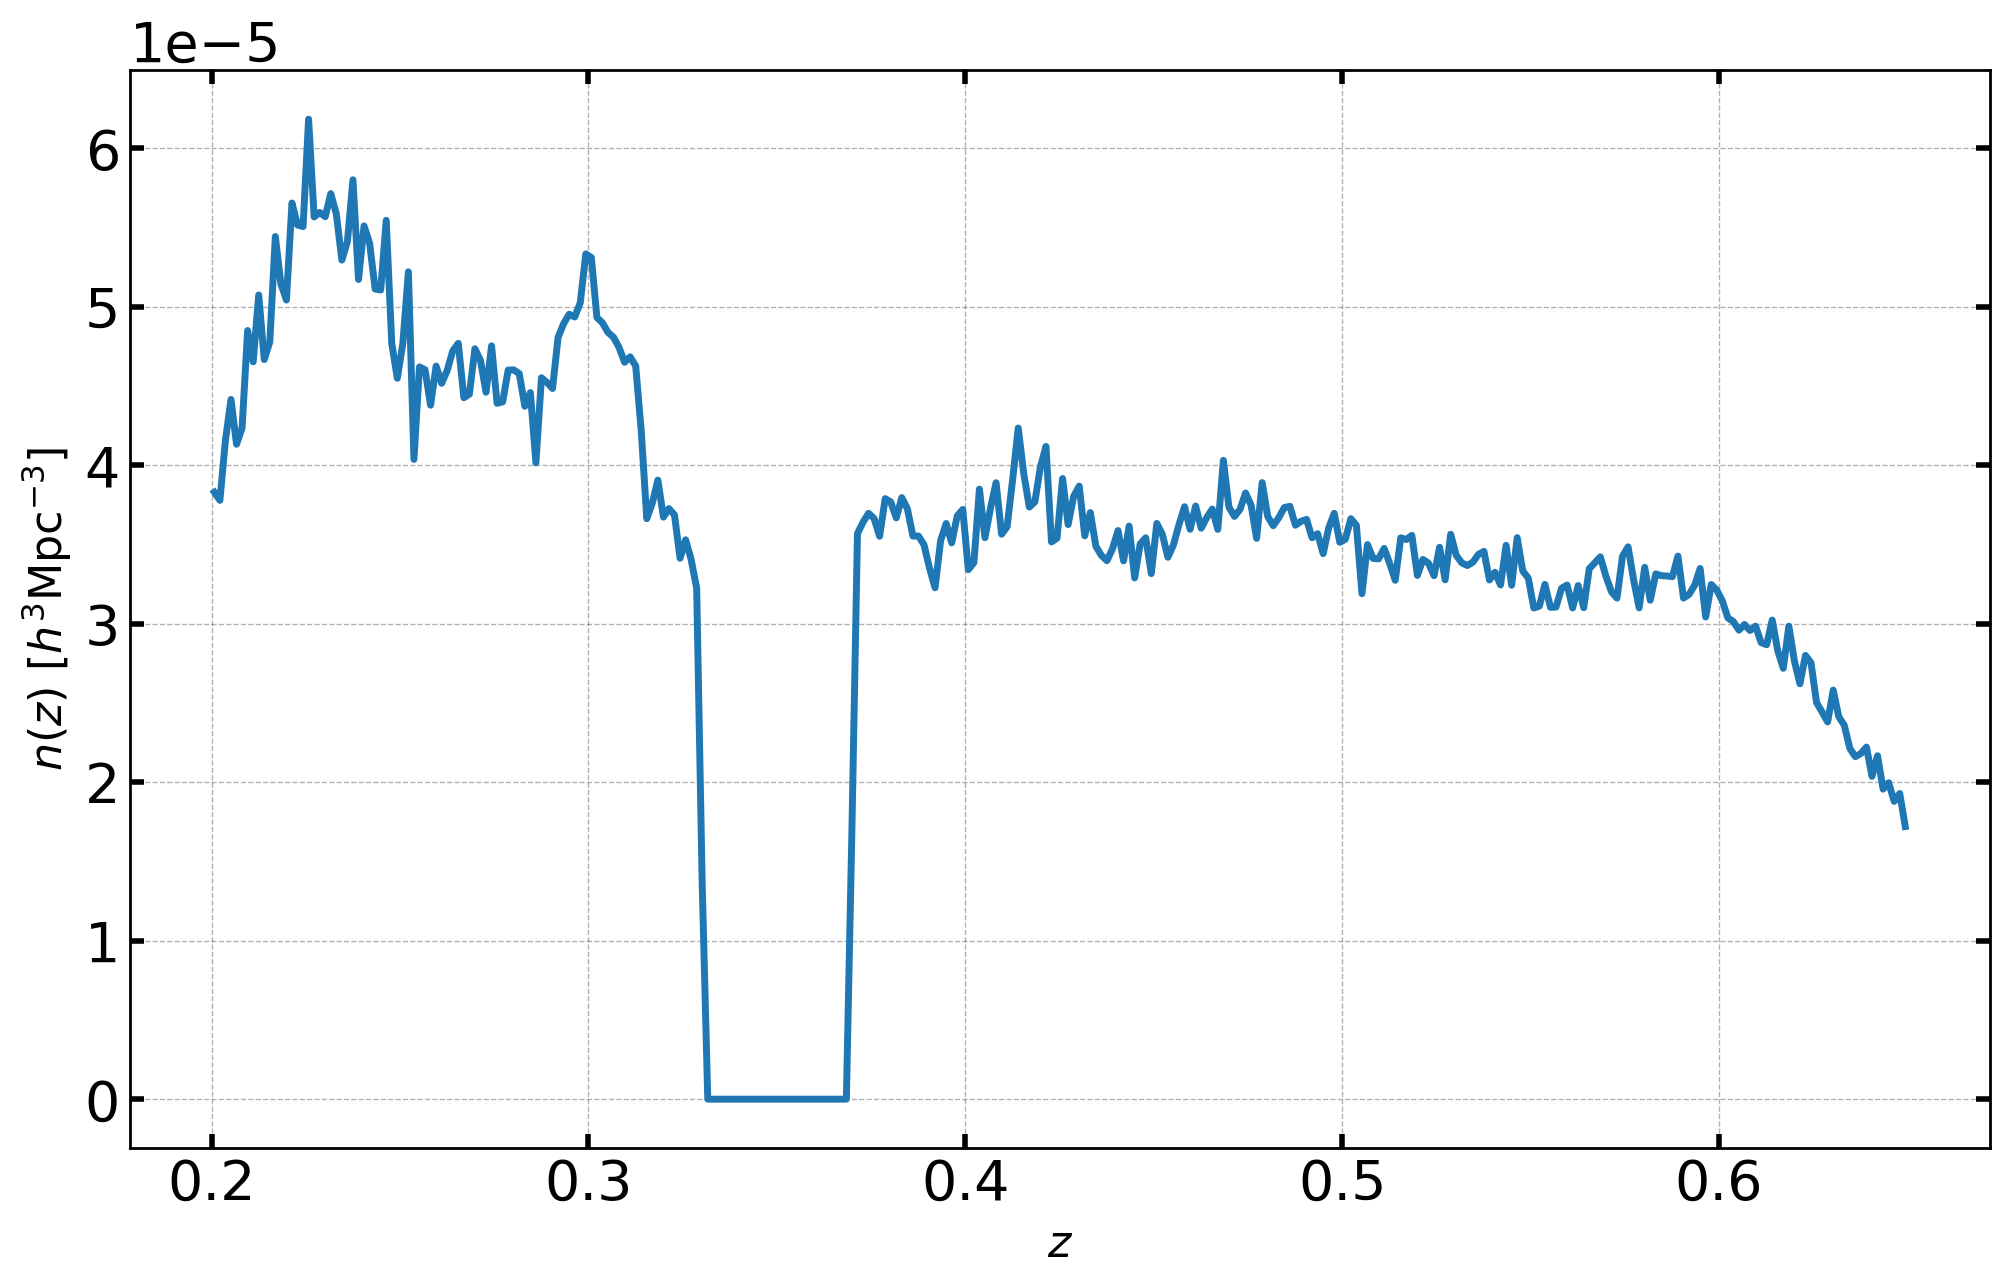

In [58]:
# the sky fraction, used to compute volume in n(z)
FSKY = 1. # a made-up value

# compute n(z) from the randoms
zhist = RedshiftHistogram(randoms, FSKY, cosmo, redshift='z')

# re-normalize to the total size of the data catalog
alpha = 1.0 * data.csize / randoms.csize

# add n(z) from randoms to the FKP source
nofz = InterpolatedUnivariateSpline(zhist.bin_centers, alpha*zhist.nbar)

# plot
plt.plot(zhist.bin_centers, alpha*zhist.nbar)
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$n(z)$ $[h^{3} \mathrm{Mpc}^{-3}]$", fontsize=16)

In [59]:
# add the n(z) columns to the FKPCatalog
randoms['NZ'] = nofz(randoms['z'])
data['NZ'] = nofz(data['z'])

In [60]:
# initialize the FKP source
fkp = FKPCatalog(data, randoms)

# print out the columns
print("columns in FKPCatalog = ", fkp.columns)

columns in FKPCatalog =  ['data/FKPWeight', 'data/NZ', 'data/Position', 'data/Selection', 'data/Value', 'data/Weight', 'data/dec', 'data/ra', 'data/z', 'randoms/FKPWeight', 'randoms/NZ', 'randoms/Position', 'randoms/Selection', 'randoms/Value', 'randoms/Weight', 'randoms/dec', 'randoms/ra', 'randoms/weight', 'randoms/z']


## Adding FKP Weights

Here, we add a column ``FKPWeight`` that gives the appropriate FKP weight for each catalog. The FKP weights are given by:

$$
w_\mathrm{FKP} = \frac{1}{1 + n(z)P_0}.
$$

Here, we use a value of $P_0 = 2 \times 10^4 \ h^{-3} \mathrm{Mpc}^3$.

I took this value from: https://arxiv.org/pdf/1608.05446.pdf

In [61]:
fkp['data/FKPWeight'] = 1.0 / (1 + fkp['data/NZ'] * 2e4)
fkp['randoms/FKPWeight'] = 1.0 / (1 + fkp['randoms/NZ'] * 2e4)

## Computing the Multipoles
To compute the multipoles, first we convert our ``FKPCatalog`` to a mesh object, specifying the number of mesh cells per side, as well as the names of the $n(z)$ and weight columns. 

If a Cartesian box size is not specified by the user, 
the size will be computed from the maximum extent of the ``Position`` column automatically.

In [62]:
mesh = fkp.to_mesh(Nmesh=512, nbar='NZ', fkp_weight='FKPWeight', window='tsc')

In [63]:
# compute the multipoles
r = ConvolvedFFTPower(mesh, poles=[0,2], dk=5e-3, kmin=0., kmax=1.5)
# r00 = FFTPower(mesh, mode='1d', los=[1,0,0], kmin=0.005, kmax=1000, dk=0.05)


/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


In [64]:
for key in r.attrs:
    print("%s = %s" % (key, str(r.attrs[key])))

poles = [0, 2]
dk = 0.005
kmin = 0.0
kmax = 1.5
Nmesh = [512 512 512]
BoxSize = [1834. 2722. 1692.]
BoxPad = [0.02 0.02 0.02]
BoxCenter = [ 751.97005021  220.1749974  -686.59901032]
mesh.resampler = tsc
mesh.interlaced = False
alpha = 0.025
data.norm = 6.970195615995112
randoms.norm = 7.003724424827328
shotnoise = 30084.13950746676
data.N = 583043
data.W = 583043.0
data.W2 = 345060.37760168186
data.num_per_cell = 0.0025709001541263004
randoms.N = 23321720
randoms.W = 23321720.0
randoms.W2 = 13674271.358386848
randoms.num_per_cell = 0.10188126085986829
data.ext = 1
randoms.ext = 1


Text(0, 0.5, '$k \\times P_\\ell$ [$h^{-3} \\mathrm{Mpc}^3$]')

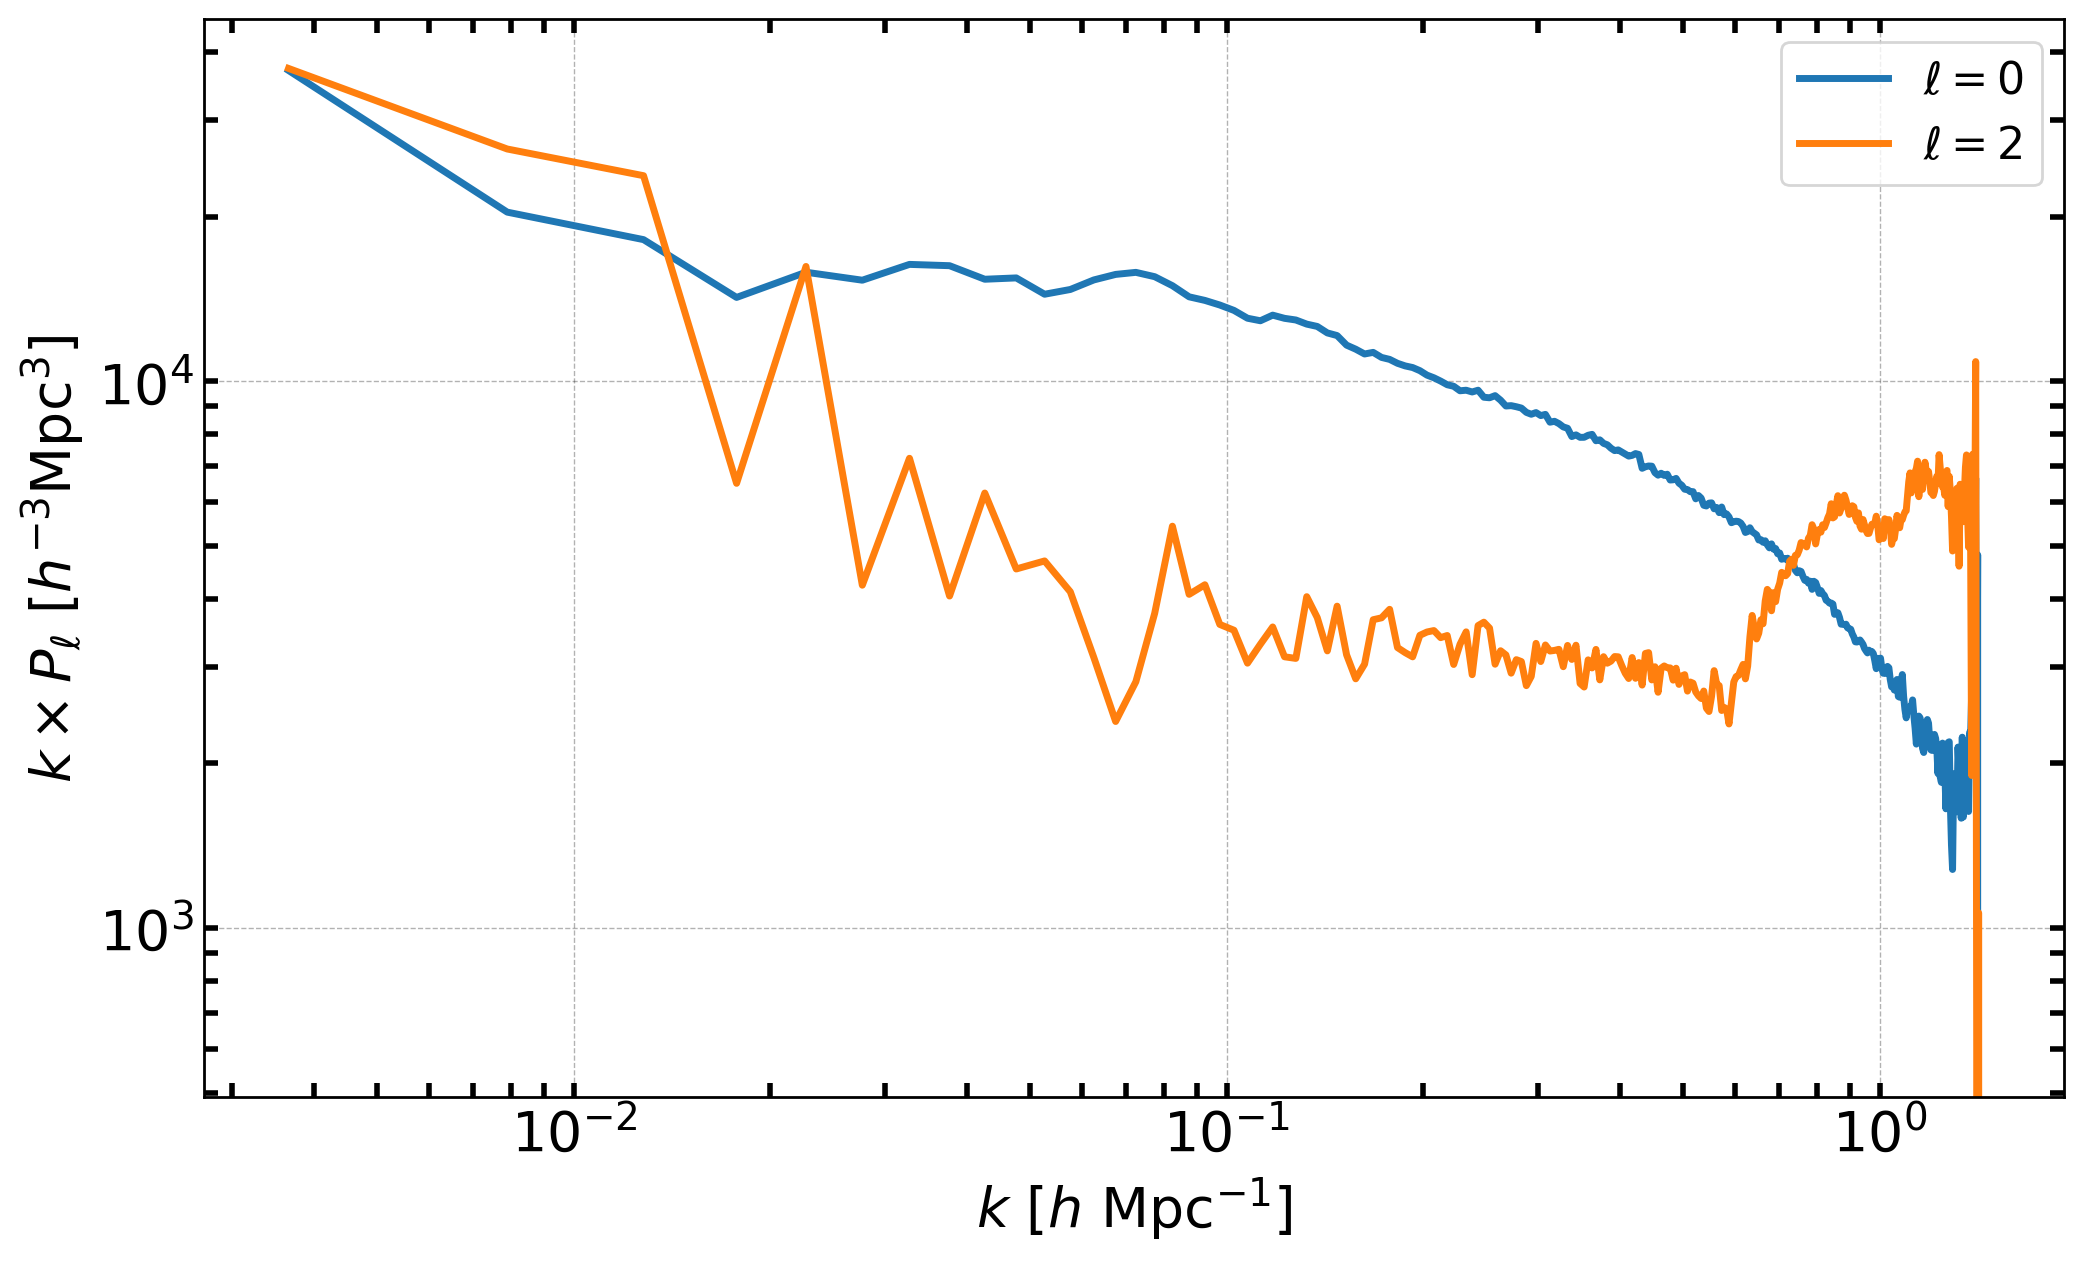

In [65]:
poles = r.poles
plt.loglog()
for ell in [0, 2]:
    label = r'$\ell=%d$' % (ell)
    P = poles['power_%d' %ell].real
    if ell == 0: P = P - poles.attrs['shotnoise']
    plt.plot(poles['k'], poles['k']*P, label=label)

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k \times P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]")
# plt.xlim(0.01, 0.3)

## DES Y3

In [20]:
mesh = fkp.to_mesh(Nmesh=512, nbar='NZ', fkp_weight='FKPWeight', window='tsc')

In [31]:
# compute the multipoles
r = ConvolvedFFTPower(mesh, poles=[0,2], dk=5e-3, kmin=0., kmax=1.5)
# r00 = FFTPower(mesh, mode='1d', los=[1,0,0], kmin=0.005, kmax=1000, dk=0.05)


/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


In [32]:
for key in r.attrs:
    print("%s = %s" % (key, str(r.attrs[key])))

poles = [0, 2]
dk = 0.005
kmin = 0.0
kmax = 1.5
Nmesh = [512 512 512]
BoxSize = [1828. 2720. 1689.]
BoxPad = [0.02 0.02 0.02]
BoxCenter = [ 753.56242983  218.73972509 -685.16433314]
mesh.resampler = tsc
mesh.interlaced = False
alpha = 0.05
data.norm = 1.7288973031694586
randoms.norm = 1.7277366080437935
shotnoise = 85068.03963180752
data.N = 217986
data.W = 217986.0
data.W2 = 174551.32004111417
data.num_per_cell = 0.0013005086782657666
randoms.N = 4359720
randoms.W = 4359720.0
randoms.W2 = 3491811.5506851375
randoms.num_per_cell = 0.02601602338764919
data.ext = 1
randoms.ext = 1


Text(0, 0.5, '$k \\times P_\\ell$ [$h^{-3} \\mathrm{Mpc}^3$]')

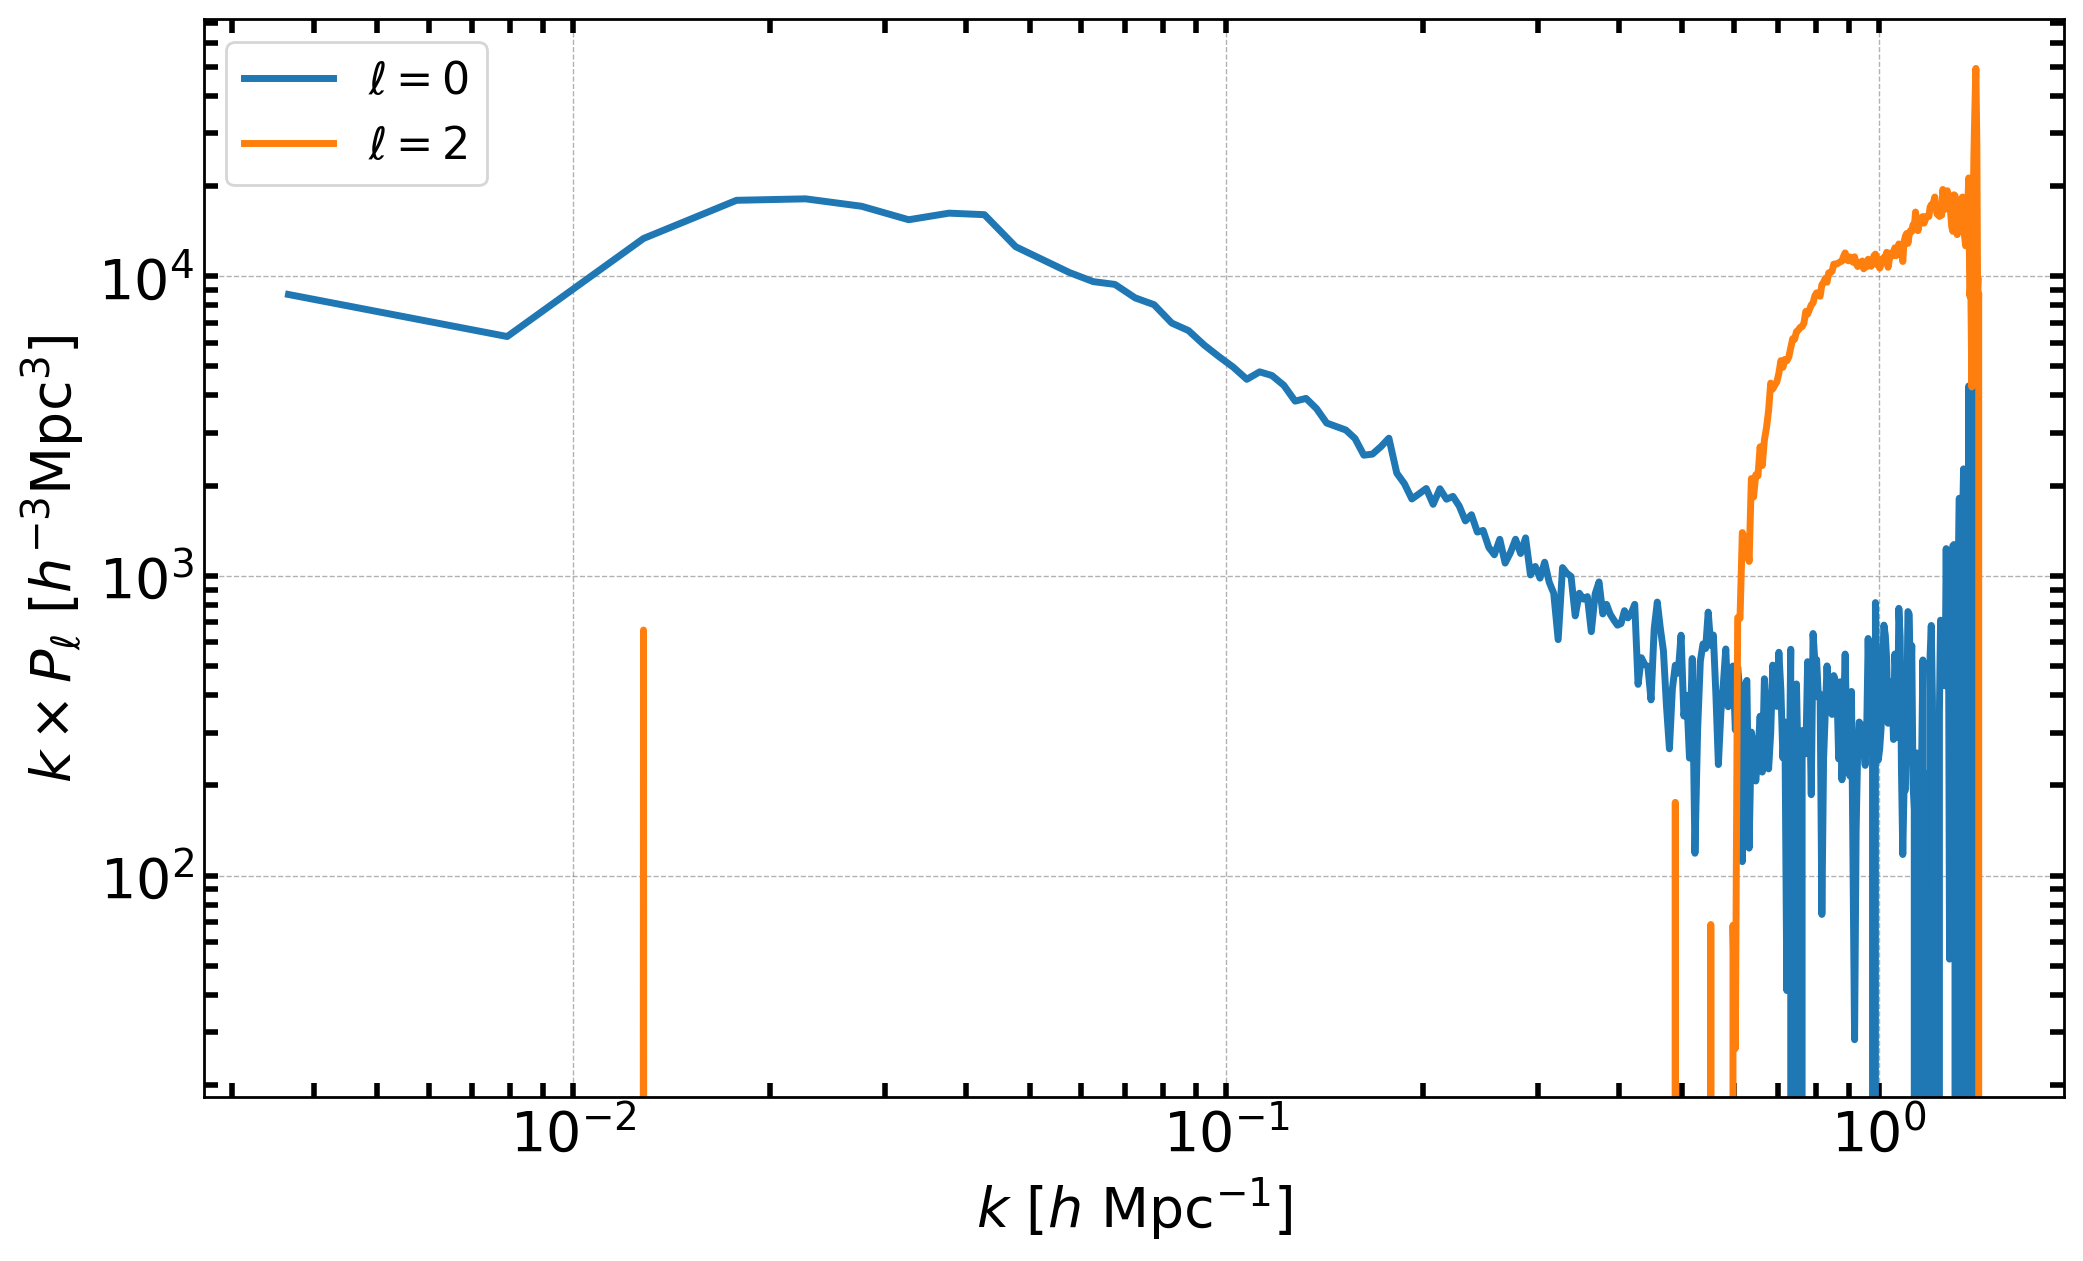

In [34]:
poles = r.poles
plt.loglog()
for ell in [0, 2]:
    label = r'$\ell=%d$' % (ell)
    P = poles['power_%d' %ell].real
    if ell == 0: P = P - poles.attrs['shotnoise']
    plt.plot(poles['k'], poles['k']*P, label=label)

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k \times P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]")
# plt.xlim(0.01, 0.3)

# Correlation Functions

In [ ]:
rbins = np.logspace(np.log10(0.7), np.log10(150), 20)
cf = SurveyData2PCF('1d', data, randoms, rbins, cosmo=cosmo, 
                    ra='ra', dec='dec', redshift='z', show_progress=True)

In [ ]:
for key in cf.attrs:
    print("%s = %s" % (key, str(cf.attrs[key])))

In [ ]:
cf.cor

In [66]:
help(SurveyData2PCF)

Help on class SurveyData2PCF in module nbodykit.algorithms.paircount_tpcf.tpcf:

class SurveyData2PCF(BasePairCount2PCF)
 |  SurveyData2PCF(mode, data1, randoms1, edges, cosmo=None, Nmu=None, pimax=None, data2=None, randoms2=None, R1R2=None, ra='RA', dec='DEC', redshift='Redshift', weight='Weight', show_progress=False, **config)
 |  
 |  Compute the two-point correlation function for observational survey data
 |  as a function of :math:`r`, :math:`(r,\mu)`, :math:`(r_p, \pi)`, or
 |  :math:`\theta` using pair counting.
 |  
 |  The Landy-Szalay estimator (DD/RR - 2 DD/RR + 1) is used to transform
 |  pair counts in to the correlation function.
 |  
 |  Parameters
 |  ----------
 |  mode : '1d', '2d', 'projected', 'angular'
 |      the type of two-point correlation function to compute; see the Notes below
 |  data1 : CatalogSource
 |      the data catalog; must have ra, dec, redshift, columns
 |  randoms1 : CatalogSource
 |      the catalog specifying the un-clustered, random distributi

In [ ]:
# poles = r00.poles
plt.loglog()
for ell in [0]:
    label = r'$\ell=%d$' % (ell)
    P = r00.power['power'].real #- r00.attrs['shotnoise']
    k = r00.power['k']
    plt.scatter(k, k*P, label=label)

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.01, 10.)